In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,roc_auc_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Header

In [6]:
data = pd.read_csv('C:/Users/HP user/PS_20174392719_1491204439457_log.csv/PS_20174392719_1491204439457_log.csv')

print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


# Exploratory Data Analysis

In [7]:
print("Number of records:\t\t",data.shape[0])
print("Number of features per record:\t",data.shape[1])

Number of records:		 6362620
Number of features per record:	 11


In [8]:
print("Any missing data?",data.isnull().sum().any())

Any missing data? False


In [9]:
#print("% of Valid transactions:",round(data.isFraud.value_counts()[0]/data.shape[0] * 100,2))
#print("% of Fraud transactions:",round(data.isFraud.value_counts()[1]/data.shape[0] * 100,2))

print("No of Valid transactions:",data.isFraud.value_counts()[0],'which is ',round(data.isFraud.value_counts()[0]/data.shape[0] * 100,2),'%')
print("No of Fraud transactions:",data.isFraud.value_counts()[1],'which is ',round(data.isFraud.value_counts()[1]/data.shape[0] * 100,2),'%')

data.isFraud.value_counts()

No of Valid transactions: 6354407 which is  99.87 %
No of Fraud transactions: 8213 which is  0.13 %


0    6354407
1       8213
Name: isFraud, dtype: int64

In [10]:
data_temp = data[data.isFlaggedFraud==1]
print("How many frauds transactions are Flagged?:")
print("\t",len(data_temp))

print("What type of transactions are they?")
print("\t",data_temp['type'].value_counts().index[0])

print("Are all these flagged also marked as Fraud Transactions?")
print("\t",data_temp['isFraud'].value_counts()[1] == len(data_temp))

How many frauds transactions are Flagged?:
	 16
What type of transactions are they?
	 TRANSFER
Are all these flagged also marked as Fraud Transactions?
	 True


In [11]:
data = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT']))]
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


# Data Visualization

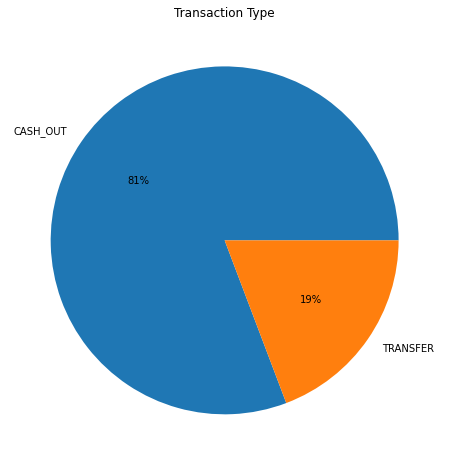

In [12]:
#create pie chart
plt.figure(figsize=(10,8))
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

# Data Visualization

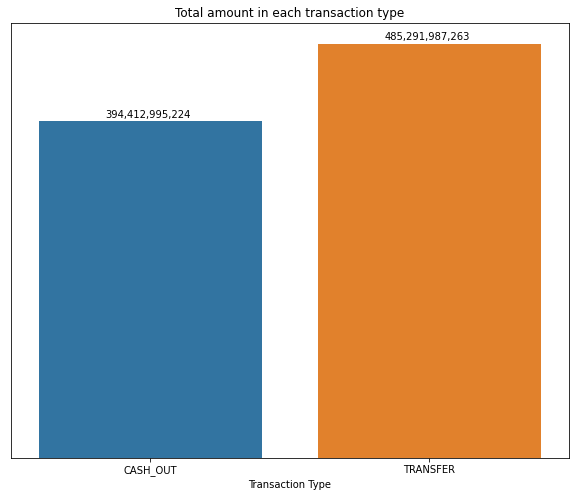

In [15]:
d = data.groupby('type')['amount'].sum()
plt.figure(figsize=(10,8))
ax = sns.barplot(x=d.index,y=d.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
    
plt.title("Total amount in each transaction type")
plt.yticks([])
plt.xlabel("Transaction Type")
plt.show()


# Data Cleaning and Standardizing Continous values

In [16]:
data.drop(['step','type','nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,181.00,181.0,0.0,0.0,0.00,1
3,181.00,181.0,0.0,21182.0,0.00,1
15,229133.94,15325.0,0.0,5083.0,51513.44,0
19,215310.30,705.0,0.0,22425.0,0.00,0
24,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [17]:
ss = StandardScaler()

data.amount         = ss.fit_transform(data[['amount']])
data.oldbalanceOrg  = ss.fit_transform(data[['oldbalanceOrg']])
data.oldbalanceDest = ss.fit_transform(data[['oldbalanceDest']])
data.newbalanceOrig = ss.fit_transform(data[['newbalanceOrig']])
data.newbalanceDest = ss.fit_transform(data[['newbalanceDest']])

# Splitting the Dataset for Training and Testing

In [18]:
X = data.drop(["isFraud"],axis=1)
y = data.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2077806, 5), (692603, 5), (2077806,), (692603,))

In [19]:
# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    
    plt.figure(figsize=(6,6))
    plt.title("Confusion Matrix")
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    

# Declaring and Training the Logistic Regression model

In [20]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

# Testing and evaluating the model

How many class does the model predict? [0 1]
Numbers in each class:		 0 : 691596
		 1 : 1007
f1 score: 0.6051854282901213
Accuracy of this model: 0.9982630742286707
recall of this model: 0.4519607843137255
precision of this model: 0.9155908639523337


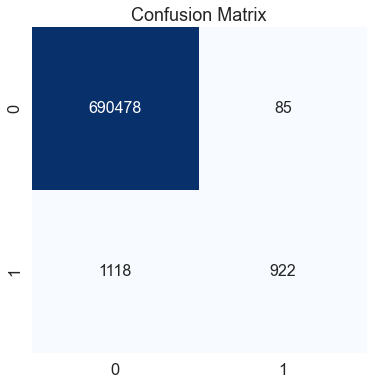

In [100]:
lr_pred = lr.predict(X_test)

print("How many class does the model predict?",np.unique( lr_pred ))
print("Numbers in each class:\t\t","0 :",len(lr_pred[lr_pred==0]))
print("\t\t 1 :",len(lr_pred[lr_pred==1]))

f1score = f1_score(y_test, lr_pred)
print('f1 score:', f1score)
acc_lr= accuracy_score(y_test, lr_pred)
print("Accuracy of this model:", acc_lr)
recallscore = recall_score(y_test, lr_pred)
print('recall of this model:', recallscore)
precisionscore = precision_score(y_test, lr_pred)
print('precision of this model:', precisionscore)
conf_matrix(y_test, lr_pred)



# Up-Sample Minority Class

In [45]:
n = data.isFraud.value_counts()[0]

# Separate majority and minority classes
df_majority = data[data.isFraud==0]
df_minority = data[data.isFraud==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=n,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print("The new class count are :")
df_upsampled.isFraud.value_counts()


The new class count are :


0    2762196
1    2762196
Name: isFraud, dtype: int64

# Splitting the dataset/ Declaring and training the Logistic regression model

In [48]:
X = df_upsampled.drop(["isFraud"],axis = 1)
y = df_upsampled.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)


lr = LogisticRegression(solver='newton-cg', max_iter = 1000)
lr.fit(X_train, y_train)



LogisticRegression(max_iter=1000, solver='newton-cg')

# Testing and evaluating the Logistic Regression Model

Accuracy of this model:		 0.9006182037769949
f1 score for the testing data:	 0.897300371124147
recall for the testing data:	 0.8693884534300719
precision for the testing data: 0.9270639747922806


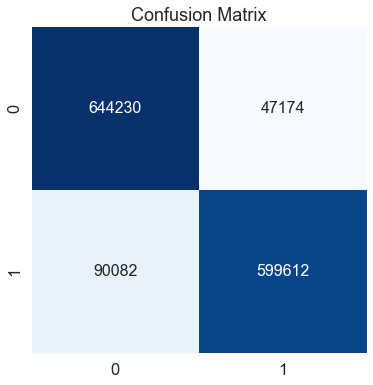

In [49]:
#Predicting on the test data
up_scale_pred = lr.predict(X_test)
acc_up_scale=accuracy_score(y_test, up_scale_pred)
print("Accuracy of this model:\t\t",acc_up_scale)
f1up_scale_pred = f1_score(y_test, up_scale_pred)
print('f1 score for the testing data:\t', f1up_scale_pred)
recallupscale = recall_score(y_test, up_scale_pred)
print('recall for the testing data:\t', recallupscale)
precisionupscale = precision_score(y_test, up_scale_pred)
print('precision for the testing data:', precisionupscale)
conf_matrix(y_test, up_scale_pred)

# Splitting the Dataset for Training and Testing

In [37]:
X = df_upsampled.drop(["isFraud"],axis = 1)
y = df_upsampled.isFraud

In [38]:
print("The new class count are :")
df_upsampled.isFraud.value_counts()

The new class count are :


0    2762196
1    2762196
Name: isFraud, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Declaring and Training the Random Forest classifier

In [40]:
rfc = RandomForestClassifier()

In [41]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

# Testing and evaluating the Random Forest Classifier

In [42]:
rfc_pred = rfc.predict(X_test)

In [43]:
f1_rfc = f1_score(y_test, rfc_pred)
print('f1 score:\t\t', f1_rfc)
acc_rfc=accuracy_score(y_test, rfc_pred) 
print("Accuracy of the model:\t", acc_rfc)
rec_rfc = recall_score(y_test, rfc_pred)
print('recall for the testing data:\t', rec_rfc)
prec_rfc = precision_score(y_test, rfc_pred)
print('precision of the model:\t\t', prec_rfc)


f1 score:		 0.9998409013660788
Accuracy of the model:	 0.9998407064524024
recall for the testing data:	 1.0
precision of the model:		 0.9996818533488551


# Confusion Matrix of the Random Forest Classifier

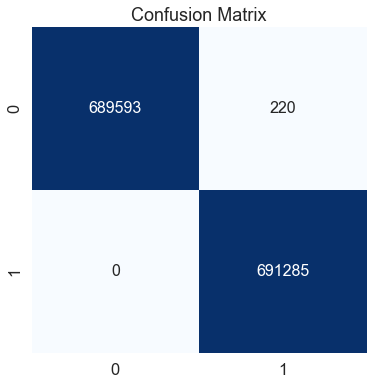

In [44]:
conf_matrix(y_test, rfc_pred)